# Option Pricing path testing for non-exact prices

In [29]:
import numpy as np
import pandas as pd

from src.evaluate import metrics as m
from src.visualization.plot_option_results import OptionPricingVisualization 
from src.evaluate.option_pricing import OptionPricingEngine

In [30]:
# Import csv
method = "Kou_Jump_Diffusion2"
method_src = "Kou_Jump_Diffusion"
n_trained = 100
n_paths = n_trained
freq = "Y"
name_string = f"{method}_{n_trained}_{n_paths}_{freq}"
n_periods = 1/12 if freq == "M" else 1

recovered_paths_df = pd.read_csv("csv_export/recovered_paths_" + name_string + ".csv") + 1
underlying_paths_df = pd.read_csv("csv_export/mg_windows_" + name_string + ".csv") + 1

recovered_paths_df.columns = np.linspace(0, n_periods, recovered_paths_df.shape[1])
underlying_paths_df.columns = np.linspace(0, n_periods, recovered_paths_df.shape[1])

In [31]:
# save paths for approximations if they do not yet exist
n_approx = 100000
approx_df_name_csv = f"csv_export/{n_approx}_{method}_paths.csv"
try:
    approx_df = pd.read_csv(approx_df_name_csv)
except FileNotFoundError:
    from src.data.make_dataset import DataLoader
    # write to csv if doesn't exist already
    params = {
        "S0": 1., 
        "mu": 0.12, 
        "sigma": 0.2, 
        "lambda_": 2.0, 
        "p": 0.3, 
        "eta1": 50., 
        "eta2": 25., 
    } if method == "Kou_Jump_Diffusion1" else {
        "S0": 1., 
        "mu": 0.12, 
        "sigma": 0.2, 
        "lambda_": 2.0, 
        "p": 0.3, 
        "eta1": 25., 
        "eta2": 10., 
    } if method == "Kou_Jump_Diffusion2" else None
    params["n"] = n_approx
    params["T"] = 1
    params["n_points"] = 253
    gbm_loader = DataLoader(method=method_src, params=params, seed=42)
    approx_df = gbm_loader.create_dataset(output_type="DataFrame")
    approx_df.to_csv(approx_df_name_csv, index=False)

if freq == "M":
    approx_df = approx_df.iloc[:, :21]

In [32]:
# # Test first half of each path (optional)
# denominator = 21 if freq == "M" else 252
# n_periods *= (recovered_paths_df.shape[1]//2 / denominator)
# recovered_paths_df = recovered_paths_df.iloc[:,:(recovered_paths_df.shape[1]//2+1)]
# underlying_paths_df = underlying_paths_df.iloc[:,:(underlying_paths_df.shape[1]//2+1)]

In [33]:
r = m.print_basic_non_gbm_metrics( 
    n_periods=n_periods,
    annualization_factor = (underlying_paths_df.shape[1]-1)/n_periods, 
    ground_paths_df = underlying_paths_df, 
    recovered_paths_df = recovered_paths_df, 
    approx_df=approx_df,
    return_threshold = 0.03
)

Generated mean:	 1.00578
Input mean:	 1.02627
Approx. mean:	 1.01715
-------------------------------------
Ann. gen stdev:	 0.10645
Ann. pat stdev:	 0.25029
Ann. apr stdev:	 0.25235
-------------------------------------
gen % > 3.00%:	 0.00000
ul % > 3.00%:	 2.20238
appr % > 3.00%:	 2.25148


## Plots

In [34]:
# Parameters
S0 = 1
t = 0
K_grid = np.linspace(0.8, 1.2, 100) if freq == "M" else np.linspace(0.5, 1.5, 100)
file_name_suffix = name_string + f"_{n_approx}"

### European Options

In [35]:
european_engine = OptionPricingEngine(
    type="European", 
    S0=S0, 
    T=n_periods, 
    t=t, 
    r=r,
    ground_paths_df=underlying_paths_df, 
    gen_paths_df=recovered_paths_df,
    approx_exact=True
)
# calculate all values (option prices & deviations) for different strike prices (K values)
european_engine.calc_all_K(K_grid, approx_df=approx_df)

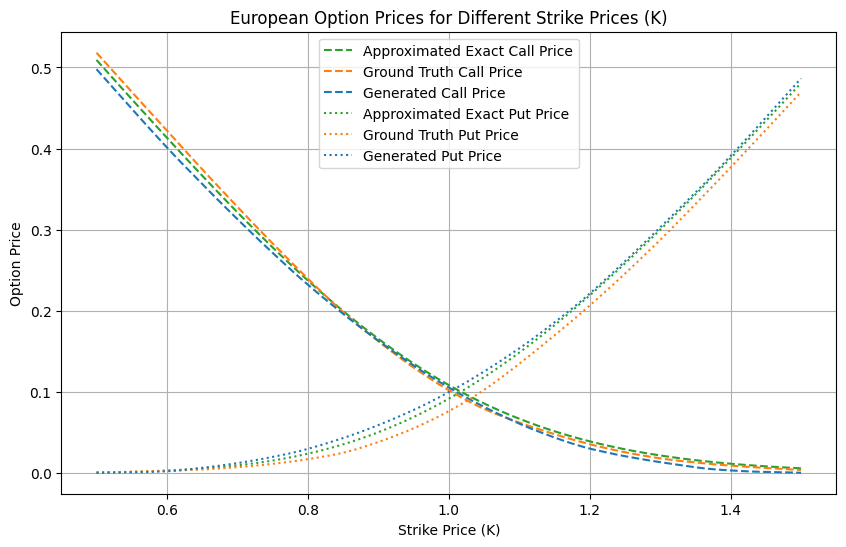

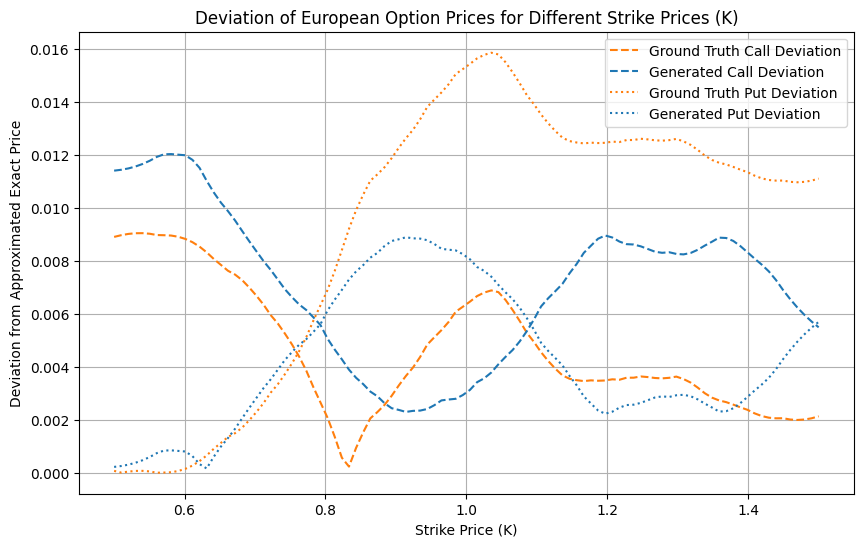

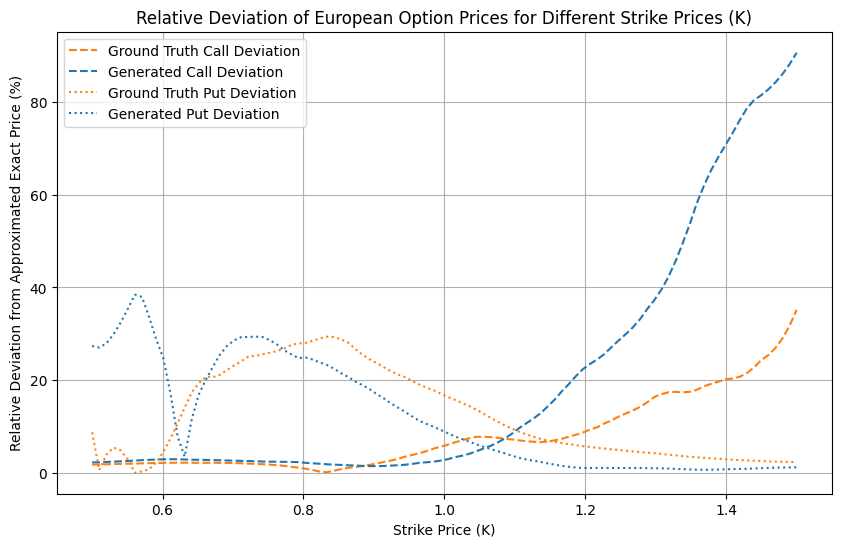

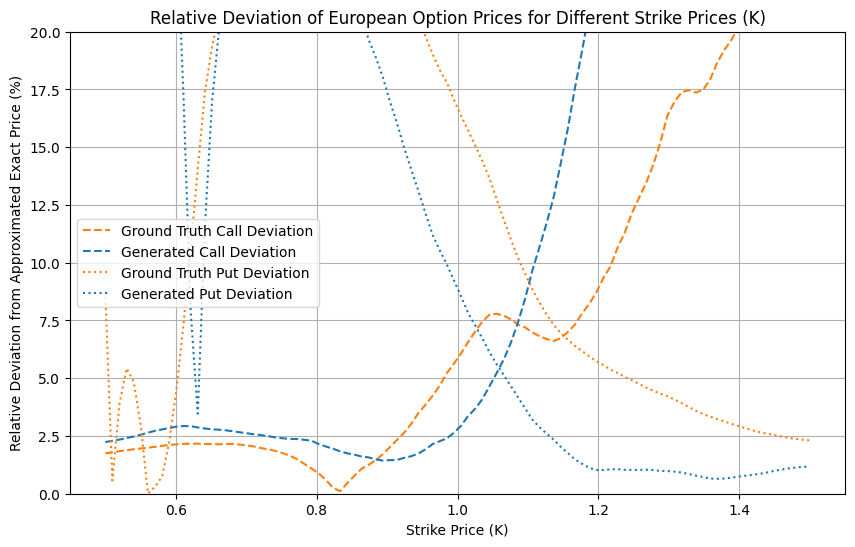

In [36]:
# Plot all types of plots
european_plotter = OptionPricingVisualization(european_engine, exact_label="Approximated Exact ", file_name=file_name_suffix)
european_plotter.plot_option_prices()
european_plotter.plot_option_price_deviation()
european_plotter.plot_option_price_deviation_relative()
european_plotter.plot_option_price_deviation_relative(zoom_ylimits=(0,20))

### Lookback Options

In [37]:
lookback_engine = OptionPricingEngine(
    type="Lookback", 
    S0=S0, 
    T=n_periods, 
    t=t, 
    r=r,
    ground_paths_df=underlying_paths_df, 
    gen_paths_df=recovered_paths_df,
    approx_exact=True
)
# calculate all values (option prices & deviations) for different maturity dates (T values)
lookback_engine.calc_all_T(approx_df=approx_df)

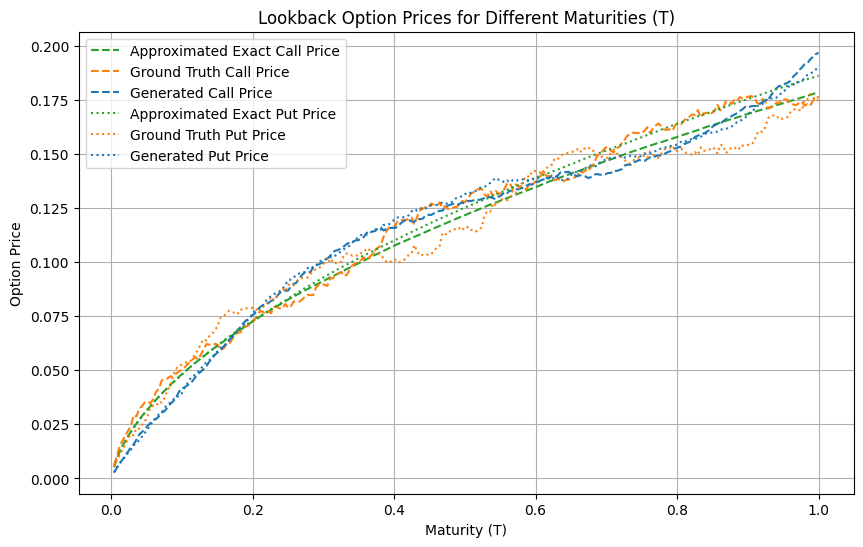

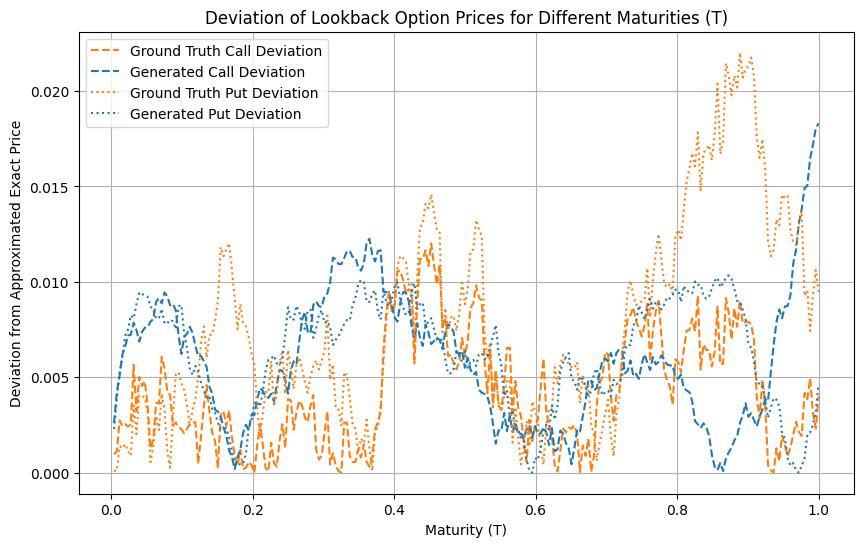

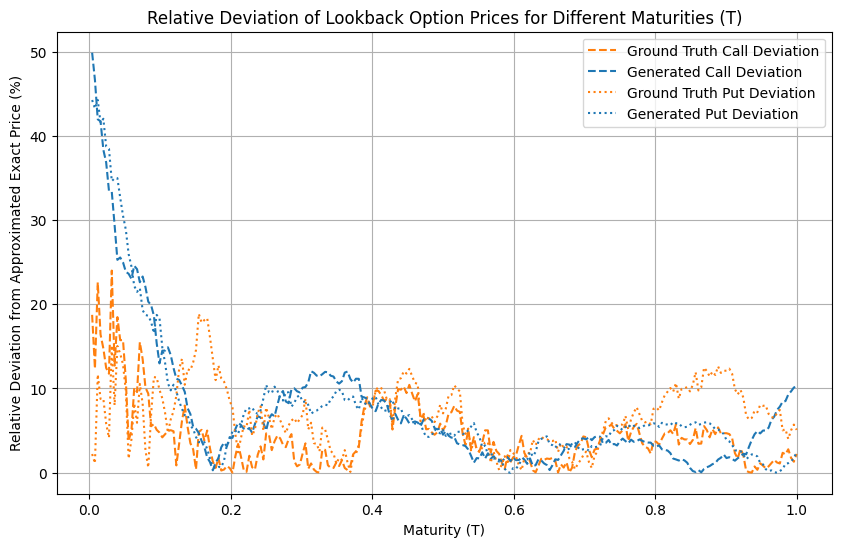

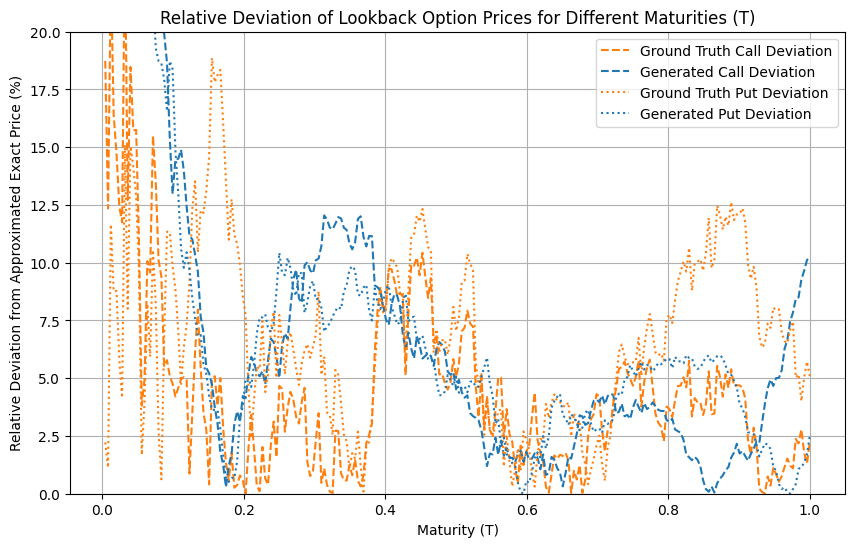

In [38]:
# Plot all types of plots
lookback_plotter = OptionPricingVisualization(lookback_engine, exact_label="Approximated Exact ", file_name=file_name_suffix)
lookback_plotter.plot_option_prices()
lookback_plotter.plot_option_price_deviation()
lookback_plotter.plot_option_price_deviation_relative()
lookback_plotter.plot_option_price_deviation_relative(zoom_ylimits=(0,20))

### Asian (Geometric)

In [39]:
geom_asian_engine = OptionPricingEngine(
    type="Asian", 
    S0=S0, 
    T=n_periods, 
    t=t, 
    ground_paths_df=underlying_paths_df, 
    gen_paths_df=recovered_paths_df, 
    r = r,
    approx_exact=True
)
# calculate all values (option prices & deviations) for different strike prices (K values)
geom_asian_engine.calc_all_K(K_grid, approx_df=approx_df)

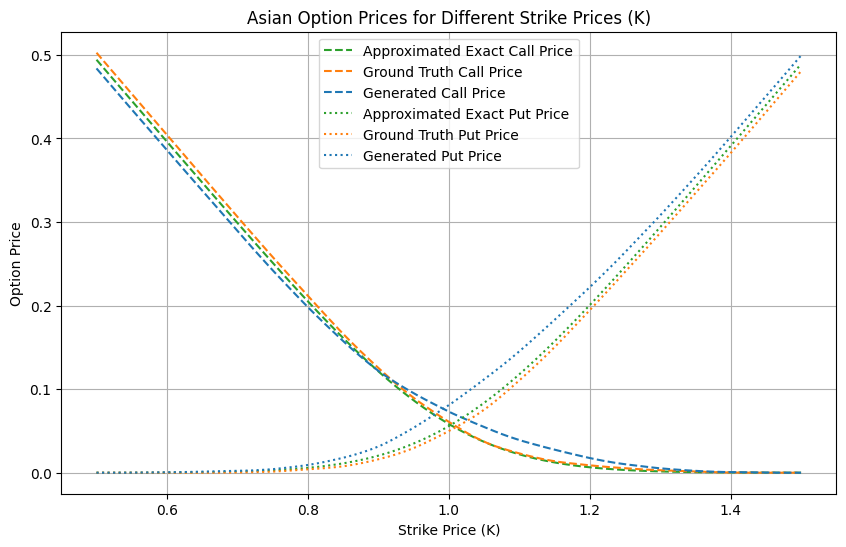

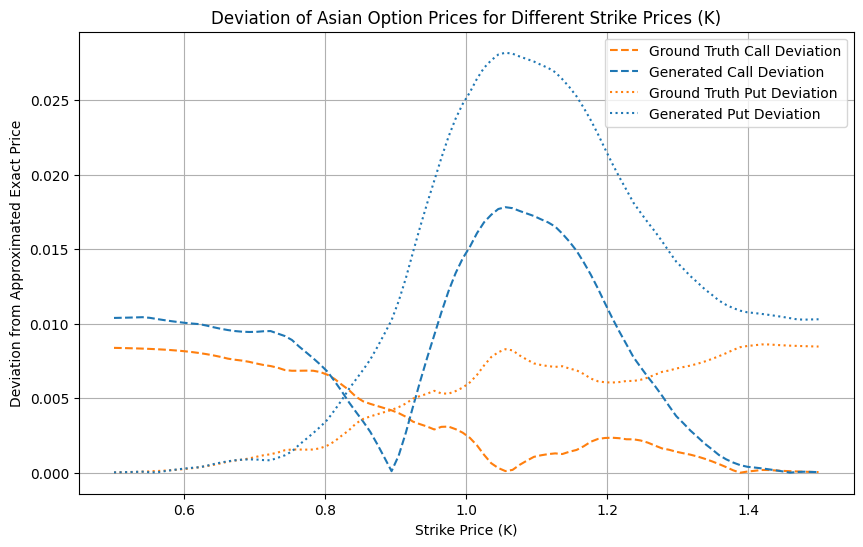

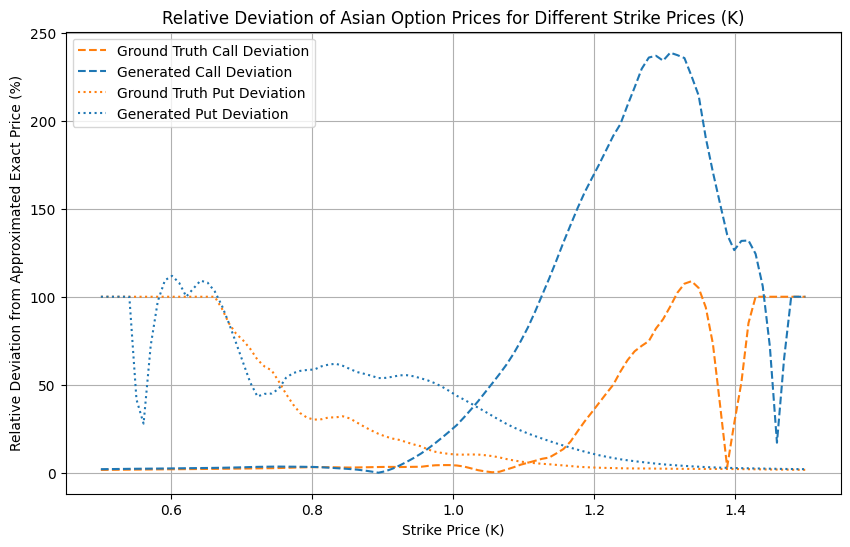

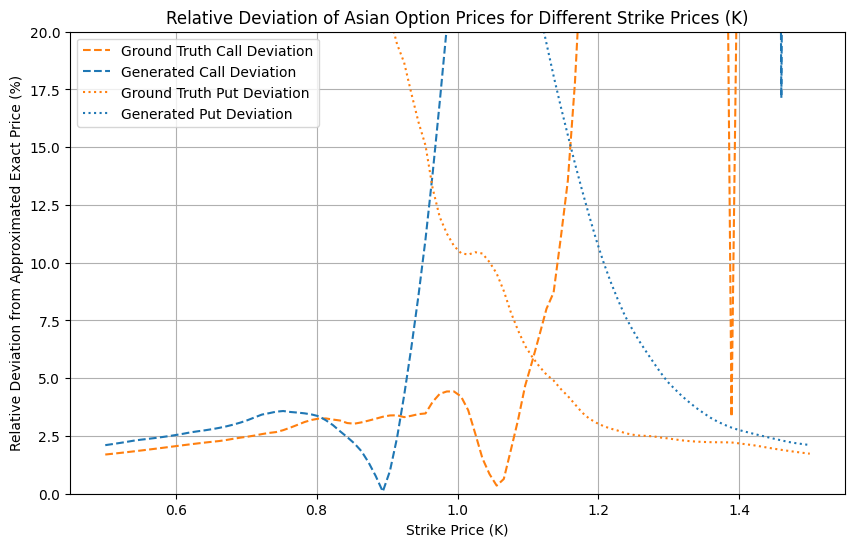

In [40]:
# Plot all types of plots
geom_asian_plotter = OptionPricingVisualization(geom_asian_engine, exact_label="Approximated Exact ", file_name=file_name_suffix)
geom_asian_plotter.plot_option_prices()
geom_asian_plotter.plot_option_price_deviation()
geom_asian_plotter.plot_option_price_deviation_relative()
geom_asian_plotter.plot_option_price_deviation_relative(zoom_ylimits=(0,20))

## Latex Export (To be updated)

In [41]:
# # K values to loop over 
# K_values = np.concatenate((np.linspace(0.8, 0.95, 4), np.linspace(0.96, 1.05, 10), np.linspace(1.1, 1.25, 4)))

# # Store results
# results = []

# for K in K_values:
#     d1 = (np.log(S0/K) + (r + sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))
#     d2 = d1 - sigma*np.sqrt(T-t)

#     exact_call_price = S0*norm.cdf(d1) - K*np.exp(-r*(T-t))*norm.cdf(d2)
#     exact_put_price = K*np.exp(-r*(T-t)) - S0 + exact_call_price

#     mc_call_gen_price = np.mean(np.exp(-r*(T-t))*np.maximum(recovered_paths_df.iloc[:, -1] - K, 0))
#     mc_call_ul_price = np.mean(np.exp(-r*(T-t))*np.maximum(underlying_paths_df.iloc[:, -1] - K, 0))

#     mc_put_gen_price = np.mean(np.exp(-r*(T-t))*np.maximum(K - recovered_paths_df.iloc[:, -1], 0))
#     mc_put_ul_price = np.mean(np.exp(-r*(T-t))*np.maximum(K - underlying_paths_df.iloc[:, -1], 0))

#     gen_call_deviation = mc_call_gen_price - exact_call_price 
#     ul_call_deviation = mc_call_ul_price - exact_call_price

#     gen_put_deviation = mc_put_gen_price - exact_put_price
#     ul_put_deviation = mc_put_ul_price - exact_put_price

#     results.append([
#         K, 
#         exact_call_price, 
#         mc_call_gen_price, 
#         gen_call_deviation, 
#         mc_call_ul_price, 
#         ul_call_deviation,
#         exact_put_price,
#         mc_put_gen_price, 
#         gen_put_deviation, 
#         mc_put_ul_price, 
#         ul_put_deviation
#     ])

# # Create LaTeX table
# latex_table = """
# \\begin{table}[H]
# \\centering
# \\begin{tabular}{
# """ 
# latex_table += "|C{0.8cm}||C{1.7cm}|C{1.8cm}C{0cm}|C{1.8cm}C{0cm}||C{1.7cm}|C{1.8cm}C{0cm}|C{1.8cm}C{0cm}|}\n"
# latex_table += """
# \\hline
# $K$ & Exact Call Price & Gen Call Price & & UL Call Price & & Exact Put Price & Gen Put Price & & UL Put Price & \\\\
# \\hline
# """

# for row in results:
#     latex_table += " & ".join(
#         [
#             f"{row[i]:.2f}" if i==0 else 
#             f"{row[i]:.6f}" if i==1 or i==6 else 
#             "" if i==3 or i==5 or i==8 or i==10 else
#             f"{row[i]:.6f} ({row[i+1]:.4f})" for i in range(len(row))
#         ]
#     ) + " \\\\ \\hline \n"

# latex_table += "\n\\end{tabular}\n\\caption{Option Prices and Deviations}\n\\label{tab:option_prices}\n\\end{table}"

# print(latex_table)
